# Forrest Cover Type Prediction

### w207 Final Project, Spring 2022

Oren Carmeli, Sam Stephens, Stephen Bridwell, Jon Hand.

# Outline

1. Introduction
2. Exploratory Data Analysis (EDA)
3. Baseline Models
4. Generalize Step Optimization 
    + feature engineering
    + hyperparameters
5. Model Comparisons
6. Conclusion
7. Appendix

______________________________________________________________________________________________________________________

# 1) Introduction

### Dataset

The dataset is part of a public competition on [kaggle](https://www.kaggle.com/c/forest-cover-type-prediction/data) that includes recorded attributes of four wilderness areas located in the Roosevelt National Forest of northern Colorado. Each observation (i.e record in the dataset) is a 30m x 30m patch of land. It includes 10 features in raw form (not scaled) as well as binary flags for qualitative independent variables such as wilderness areas and soil type.


### Business Problem
Understanding forest composition is a valuable aspect of managing the health and vitality of our wilderness areas. Classifying cover type can help further research regarding forest fire susceptibility, the spread of the Mountain Pine Beetle infestion, and de-reforestation concerns [[link]](http://cs229.stanford.edu/proj2014/Kevin%20Crain,%20Graham%20Davis,%20Classifying%20Forest%20Cover%20Type%20using%20Cartographic%20Features.pdf).


### Inference Problem

The inference problem is to predict the forest cover type (the predominant kind of tree cover) from strictly cartographic variables (as opposed to remotely sensed data). Specifically, our goal is to build a model that maps the cartographic variables (X) to predict a forecast cover type (Y). The data fields are defined below;

#### Data Fields (X)
- Elevation - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope - Slope in degrees
- Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice
- Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation

#### Data Fields (Y)
- Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

The integer cover type value corresponds to the following names;
1. Spruce/Fir
2. Lodgepole Pine
3. Ponderosa Pine
4. Cottonwood/Willow
5. Aspen
6. Douglas-fir
7. Krummholz

# 2) Exploratory Data Analysis (EDA)

### Load Packages

In [47]:
import pandas as pd 
import numpy as np
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, LinearRegression
import warnings
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import  GradientBoostingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC, LinearSVC 
from sklearn.neural_network import MLPClassifier

from sklearn import tree
from sklearn.decomposition import PCA, SparsePCA

from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import json
import pickle
from IPython.display import Image
from itertools import combinations

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

k_folds = 5
%matplotlib inline

### Create Train, Dev, & Test Objects

In [2]:
np.random.seed(0)

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# load data

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# set up modeling datasets

# X = all but last column 
X_train = np.array(train.iloc[:,:-1])
X_test = np.array(test)

# Y = last column only
Y_train = np.array(train.iloc[:,-1].tolist())

# build dev set based on random subset (20% of train data)
shuffle = np.random.permutation(np.arange(X_train.shape[0]))
X_train, Y_train = X_train[shuffle], Y_train[shuffle]

dev_size = round(X_train.shape[0] * 0.2)
dev_data, dev_labels = X_train[:dev_size], Y_train[:dev_size]
train_data, train_labels = X_train[dev_size:], Y_train[dev_size:]
test_data = X_test

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# set up dataset with cover type names for readible EDA

# append cover type labels
label_categories = ['Spruce/Fir', 
                    'Lodgepole Pine', 
                    'Ponderosa Pine', 
                    'Cottonwood/Willow', 
                    'Aspen',
                    'Douglas-fir',
                    'Krummholz']
label_categories = pd.DataFrame(data = zip(label_categories,list(range(1,8,1))), columns = ['Cover_Type_Name','Cover_Type'])
train_df = train.merge(label_categories, left_on='Cover_Type', right_on='Cover_Type')

# filter to be same subset as in train_data created above
train_df = train_df.iloc[shuffle,:].iloc[dev_size:, :]


# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# show object stats

print('Train Data shape: ', train_data.shape)
print('Train Labels shape: ', train_labels.shape)
print()
print('Dev Data shape: ', dev_data.shape)
print('Dev Labels shape: ', dev_labels.shape)
print()
print('Test Data shape: ', test_data.shape)
print()
print('Column Names: ')
print(train_df.columns)

# check dev split works
#print(f'Dev split check status: {dev_data.shape[0] + train_data.shape[0] == X_train.shape[0]}')

Train Data shape:  (12096, 55)
Train Labels shape:  (12096,)

Dev Data shape:  (3024, 55)
Dev Labels shape:  (3024,)

Test Data shape:  (565892, 55)

Column Names: 
Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil

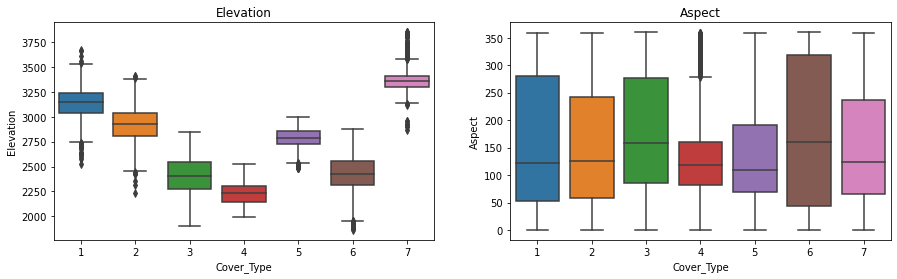

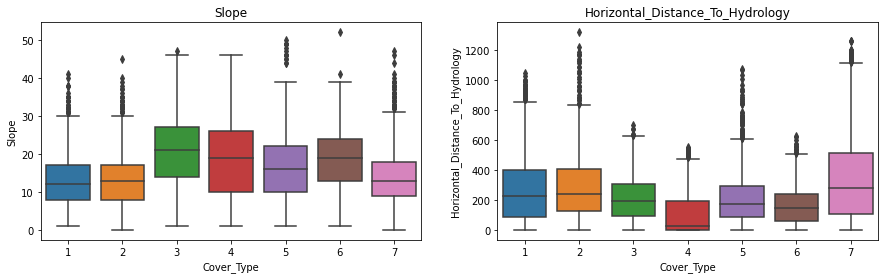

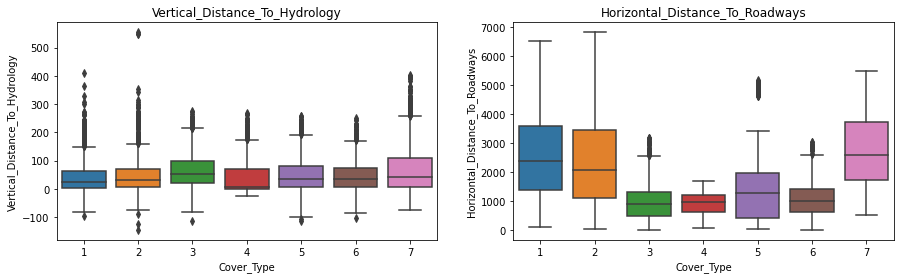

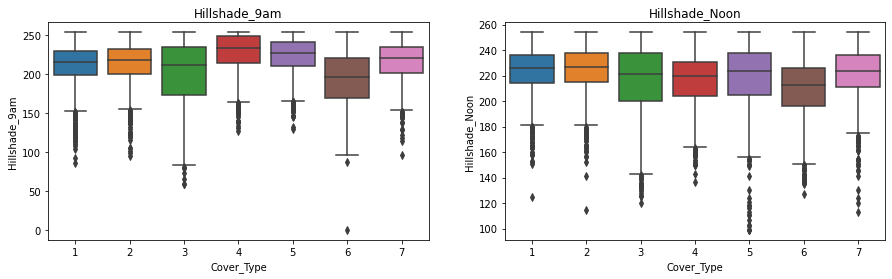

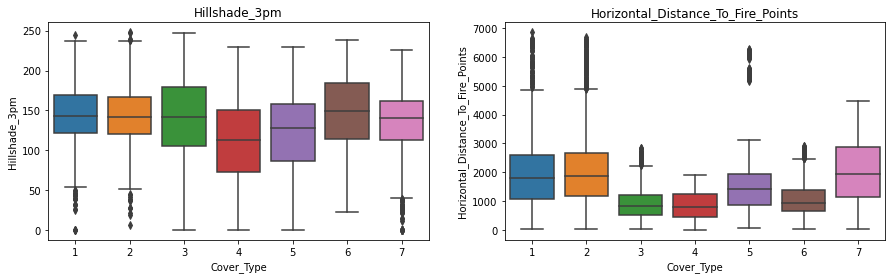

In [76]:
# plot boxplots of each cover type across first 10 feature values (excluding wilderness and soil type binary columns)

# columns to plot (2 columns plotted per row)
column_pairs_to_plot = [['Elevation','Aspect'],
                        ['Slope','Horizontal_Distance_To_Hydrology'],
                        ['Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways'],
                        ['Hillshade_9am','Hillshade_Noon'],
                        ['Hillshade_3pm','Horizontal_Distance_To_Fire_Points']]

# plot each boxplot
for column_pair in column_pairs_to_plot:
    
    fig, axs = plt.subplots(ncols = 2, figsize=(15, 4))
    
    column_1 = column_pair[0]
    column_2 = column_pair[1]
    
    sns.boxplot(x='Cover_Type', y=column_1, data=train_df, ax = axs[0])
    axs[0].set_title(column_1)
    
    sns.boxplot(x='Cover_Type', y=column_2, data=train_df, ax = axs[1])
    axs[1].set_title(column_2)
    plt.show()

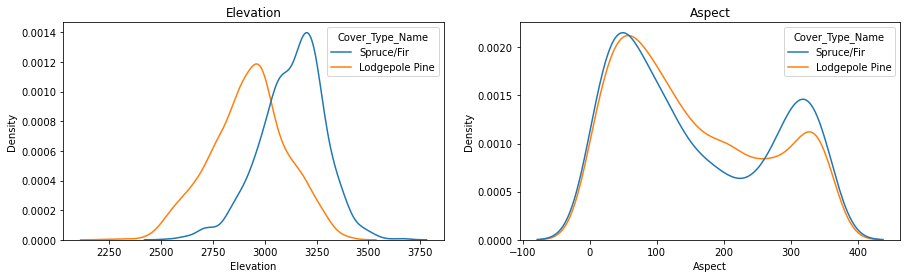

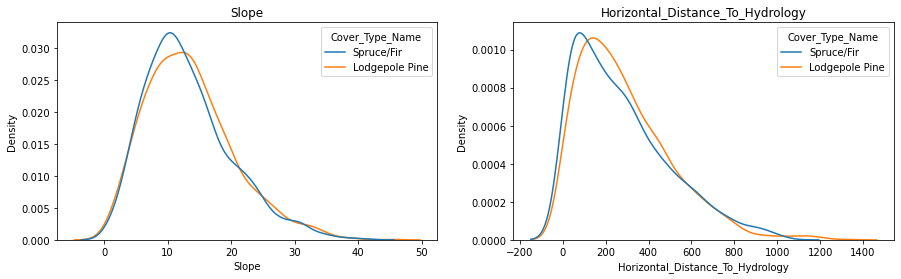

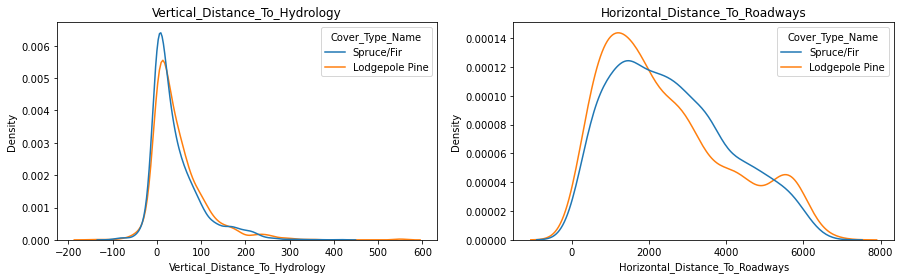

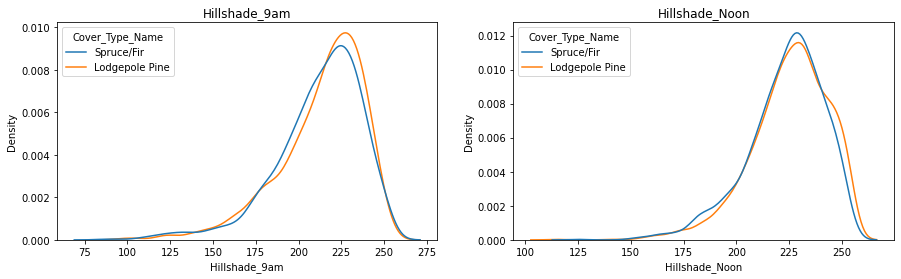

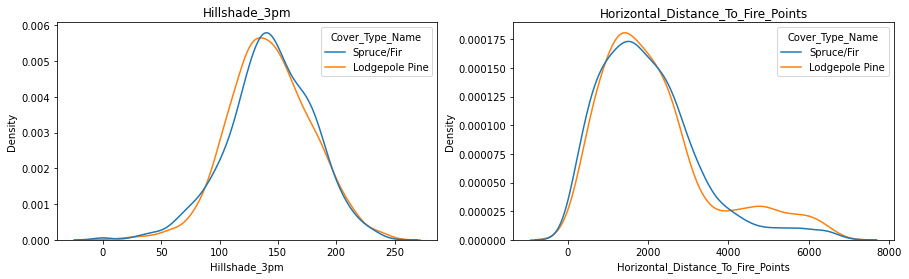

In [81]:
def density_plots(classes):
    # columns to plot (2 columns plotted per row)
    column_pairs_to_plot = [['Elevation','Aspect'],
                            ['Slope','Horizontal_Distance_To_Hydrology'],
                            ['Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways'],
                            ['Hillshade_9am','Hillshade_Noon'],
                            ['Hillshade_3pm','Horizontal_Distance_To_Fire_Points']]

    train_df_subset = train_df[train_df['Cover_Type'].isin(classes)]

    # plot each density plot
    for column_pair in column_pairs_to_plot:

        fig, axs = plt.subplots(ncols = 2, figsize=(15, 4))

        column_1 = column_pair[0]
        column_2 = column_pair[1]

        sns.kdeplot(data=train_df_subset, x=column_1, hue='Cover_Type_Name', ax = axs[0])
        axs[0].set_title(column_1)

        sns.kdeplot(data=train_df_subset, x=column_2, hue='Cover_Type_Name', ax = axs[1])
        axs[1].set_title(column_2)
        plt.show()
        
        
density_plots([1,2])

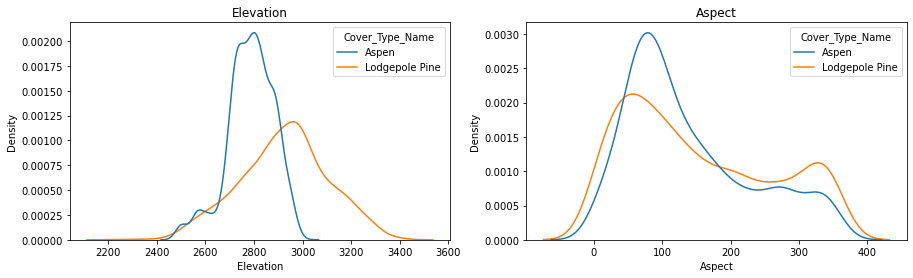

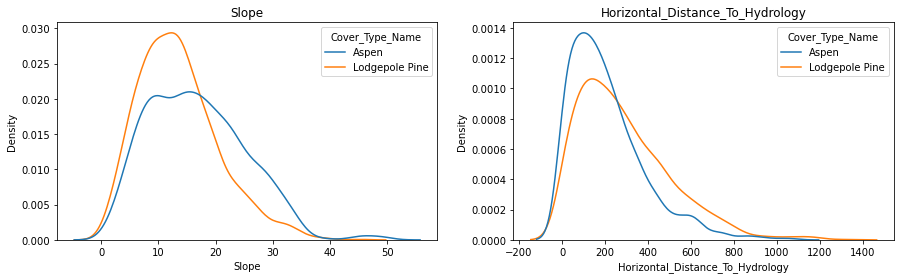

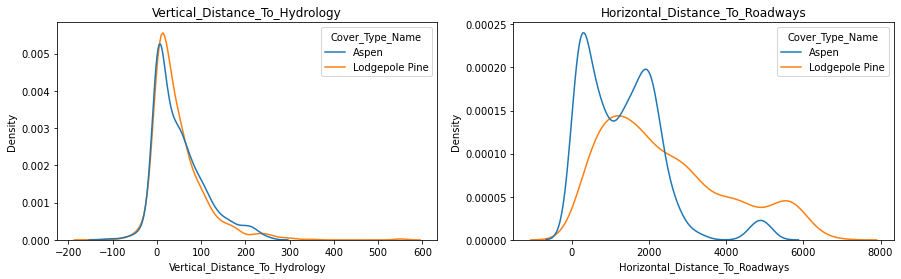

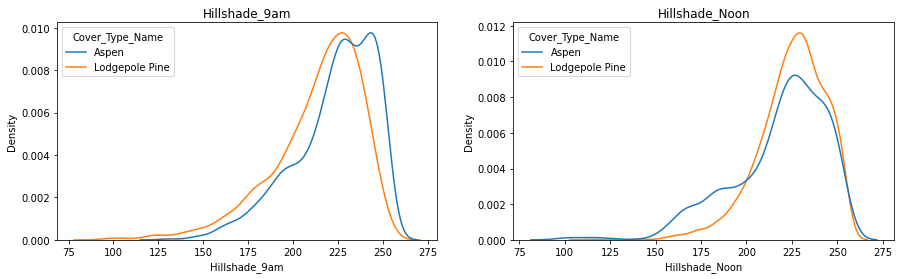

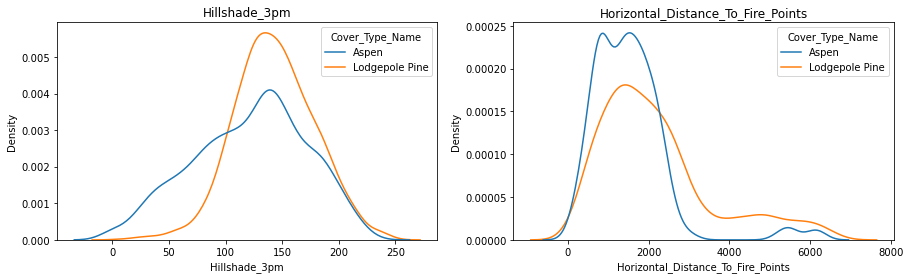

In [82]:
density_plots([2,5])